#### PRELIMINARIES

**NB this notebooks runs in Python 3.6**

In [1]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
import seaborn as sns
from skimage import io


#### FUNCTION TO MAKE A PREDICTION ERROR LOG / FLAG

**The function below is now in Bruge's Petrophysics module**

It calculates the difference between a predicted and real curve and flags differences based on a user-defined distance (in standard deviation units) from the mean difference (default method).

First introduced in MyCarta's [Geoscience_ML_notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb).


In [2]:
def error_flag(pred, actual, dev = 1.0, method = 1):
    """Calculate the difference between a predicted and an actual curve 
    and return a log flagging large differences based on a user-defined distance 
    (in standard deviation units) from the mean difference

    Matteo Niccoli, October 2018
    
    Args:
        predicted (ndarray) = predicted log
        actual (ndarray) =  original log  
        dev  (float) = standard deviations to use, default 1
        error calcluation method (int), default 1
            1: difference between curves larger than mean difference plus dev
            2: curve slopes have opposite sign
            3: curve slopes of opposite sign OR difference larger than mean plus dev
    

    Returns:
    flag (ndarray) =  error flag curve
    """   
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag


#### FIRST EXAMPLE - INVERSE GARDNER FOR VELOCITY LOG PREDICTION FROM DENSITY LOG

I will use the result from Alessandro Amato del Monte's [Inverse Gardner Notebook](https://github.com/aadm/geophysical_notes/blob/master/inverse_gardner.ipynb), where he shows how to econstruct a velocity log from density log using optimized alpha and beta parameters for his inverse gardner function, found via `scipy.curve_fit`.

In [3]:
logs1 = pd.read_csv('../data/aadm_gardner.csv')
logs1.describe()

,depth,gr,vp_hole,vp_no_hole,vp_gardner,vp_rebuilt
count,4117.000000,4117.000000,3789.000000,4117.000000,328.000000,4117.000000
mean,2326.892000,72.785125,3037.046267,2984.389630,2361.049371,2983.189822
std,181.145666,14.464120,423.877490,444.671505,51.245128,446.180764
min,2013.252800,48.368700,1439.900000,1439.900000,2238.841631,1439.900000
25%,2170.072500,60.683100,2736.700000,2611.300000,2322.305286,2609.000000
50%,2326.892100,68.026600,3074.800000,3038.158346,2356.921449,3038.158346
75%,2483.711700,83.557200,3263.700000,3251.100000,2403.044013,3251.100000
max,2640.531200,136.512800,4431.000000,4431.000000,2515.005238,4431.000000


**NB The block below breaks down with Python 3.7. Need to rework the indexing/slicing**

In [4]:
hole=((logs1.depth>2075) & (logs1.depth<2125))
flag = np.zeros(len(logs1.vp_rebuilt))
flag[hole] = error_flag(logs1.vp_rebuilt[hole], logs1.vp_no_hole[hole],  1)

In the figure below, reproduced from Alessandro's notebook, the velocity log with the missing data is displayed together with the reconstructed portion (respectively black and red curves) in the middle plot; the right plot displays a comparison between the fully-rebuilt velocity log (black curve) and the original log as it was recorded before artificially creating a gap in it (cyan curve).

I  added red color fill between the predicted and reconstructed original according to the error flag and also extra track with the error flag on its own.

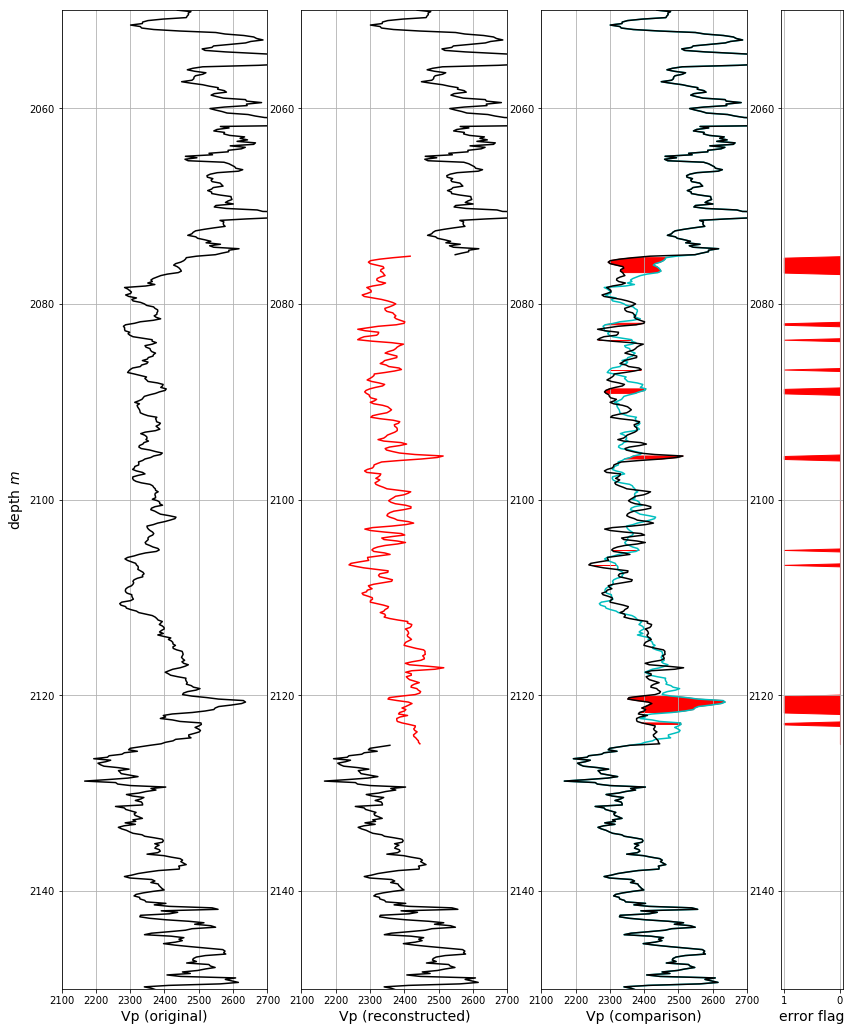

In [5]:
mi = 2100
ma = 2700
fig = plt.figure(figsize=(14,18))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.3]) 

ax = plt.subplot(gs[0])
ax.plot(logs1.vp_no_hole, logs1.depth,'-k')
ax.set_xlabel('Vp (original)', size=14)
ax.set_xlim(mi, ma)
ax.set_ylim(2150,2050)
ax.set_ylabel(r'depth $m$', size=14)
ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs1.vp_hole, logs1.depth,'-k')
ax1.plot(logs1.vp_gardner, logs1.depth,'-r')
ax1.set_xlabel('Vp (reconstructed)', size=14)
ax1.set_xlim(mi, ma)
ax1.set_ylim(2150,2050)
ax1.grid()

ax2 = plt.subplot(gs[2])
ax2.plot(logs1.vp_no_hole, logs1.depth,'-c')
ax2.plot(logs1.vp_rebuilt, logs1.depth,'-k')
ax2.fill_betweenx(logs1.depth[hole], logs1.vp_no_hole[hole],  logs1.vp_rebuilt[hole], where=flag[hole]==1,   color = 'r', label='error flag')
ax2.set_xlabel('Vp (comparison)', size=14)
ax2.set_xlim(mi, ma)
ax2.set_ylim(2150,2050)
ax2.grid()

ax3 = plt.subplot(gs[3])
ax3.fill_betweenx(logs1.depth[hole], flag[hole], 0, color = 'r')
ax3.invert_yaxis()
ax3.invert_xaxis()
ax3.set_xlabel('error flag', size=14)
ax3.set_ylim(2150,2050)
ax3.grid();

#### SECOND EXAMPLE - LINEAR MODEL REGRESSION FOR VELOCITY LOG PREDICTION FROM GR, RHOB, NPHI

I will use the latest result from MyCarta's [Geoscience ML notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb). This is an evolving notebook in which I evaluate and compare the performance of different ML methods in predicting a geophysical log from a suite of other logs. THe current result is prediction of compressional sonic log using a linear model and the Gamma Ray, Neutron Porosity, and Bulk Density logs.

In [6]:
logs2 = pd.read_csv('../data/logs2.csv')
logs2.describe()

,DEPTH,ZONE_NUM,VP,predictedVP
count,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073
std,181.053325,2.154977,433.228662,418.308545
min,2013.410000,0.000000,2046.660000,2111.090000
25%,2168.930000,4.000000,2607.125000,2675.275000
50%,2325.670000,4.000000,3050.280000,3029.160000
75%,2482.415000,5.000000,3248.900000,3242.245000
max,2639.160000,9.000000,4088.760000,4049.990000


Original versus predicted sonic, as scatter plot mimicking lines. This is your typical QC plot.

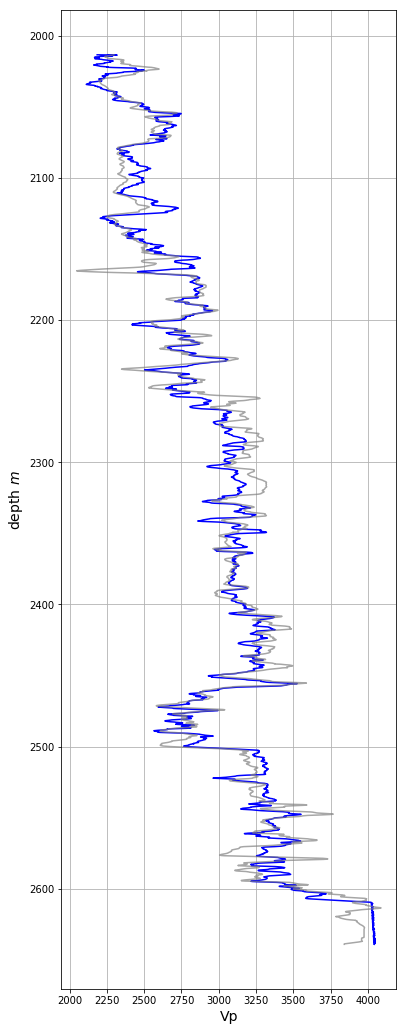

In [7]:
fig = plt.figure(figsize=(6,18))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'b')
ax1.plot( logs2["VP"], logs2["DEPTH"],'gray', alpha=0.7)
ax1.invert_yaxis()
ax1.grid()
ax1.set_ylabel(r'depth $m$', size=14)
ax1.set_xlabel('Vp', size=14);

In [8]:
flag = error_flag(logs2["predictedVP"], logs2["VP"], 1)

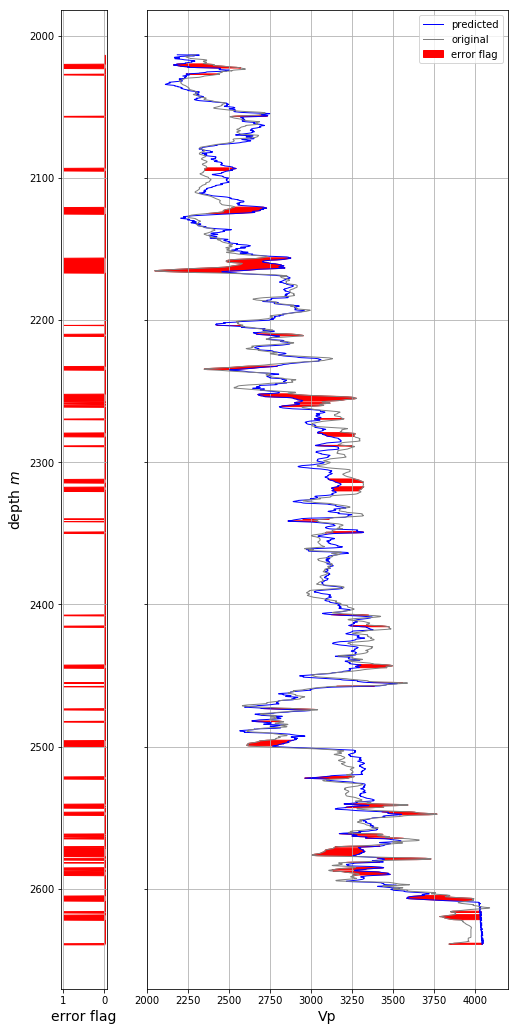

In [9]:
fig = plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=14)
ax1.set_xlim(2000,4200)
ax1.legend()   
ax1.grid();


##### ADD A RESERVOIR FLAG

Load compilation of tops. Source:

http://factpages.npd.no/FactPages/Default.aspx?nav1=wellbore&nav2=PageView|Exploration|All&nav3=2635&culture=en

In [10]:
tops = pd.read_csv('../data/qsi_well2_tops.csv')
tops

,depth,name,id
0,1807,UNDEFINED,0
1,2027,BALDER,1
2,2076,SELE,2
3,2127,LISTA,3
4,2154,HEIMDAL,4
5,2183,OWC,5
6,2458,LISTA,6
7,2491,VALE,7
8,2501,TY,8
9,2583,VALE,9


Get reservoir top and bottom depths

In [11]:
top1 = np.float64(tops.loc[tops['name']=='HEIMDAL', ['depth']].values[0]) # top of Heimdal sand
top2 = np.float64(tops.loc[tops['name']=='OWC', ['depth']].values[0]) # Oil-Water Contact
#print(top1, top2)

In [12]:
oil = np.zeros(len(logs2["DEPTH"]))
logs2['oil_zone']=oil
logs2.loc[(logs2["DEPTH"]>top1) & (logs2["DEPTH"]<top2), 'oil_zone']= 1
logs2.describe(include='all')

,DEPTH,ZONE_NUM,VP,predictedVP,oil_zone
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073,0.046173
std,181.053325,2.154977,433.228662,418.308545,0.209884
min,2013.410000,0.000000,2046.660000,2111.090000,0.000000
25%,2168.930000,4.000000,2607.125000,2675.275000,0.000000
50%,2325.670000,4.000000,3050.280000,3029.160000,0.000000
75%,2482.415000,5.000000,3248.900000,3242.245000,0.000000
max,2639.160000,9.000000,4088.760000,4049.990000,1.000000


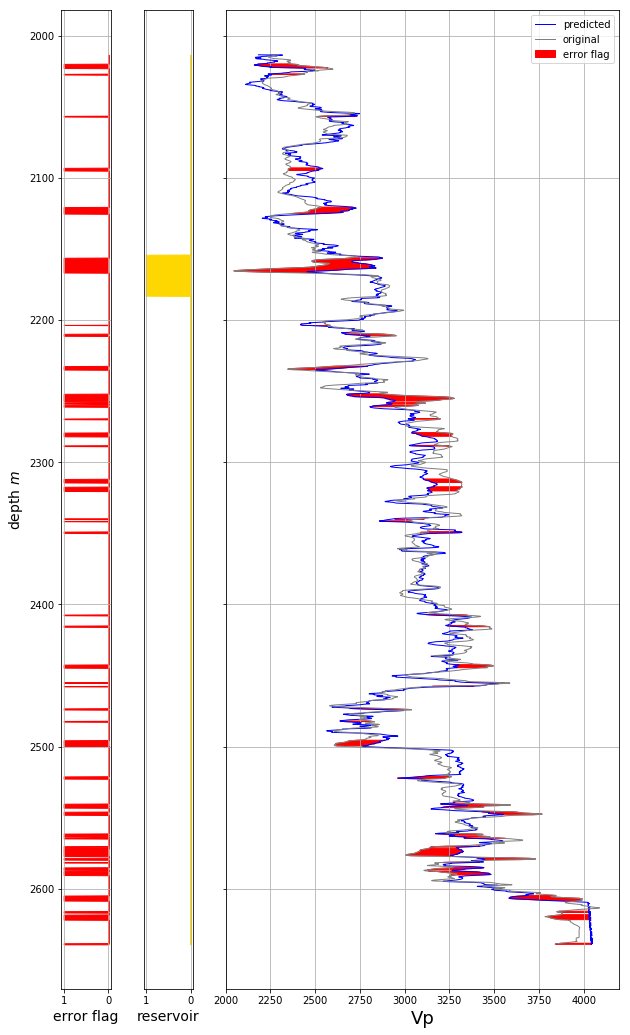

In [13]:
fig = plt.figure(figsize=(10,18))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.5,0.5, 4]) 

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)
ax.grid()

ax1 = plt.subplot(gs[2])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.set_xlim((2000, 4500))
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')


ax2 = plt.subplot(gs[1])
ax2.fill_betweenx(logs2['DEPTH'],  0, logs2['oil_zone'],  color = 'gold')
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_yticks([])
ax2.set_xlabel('reservoir', size=14)
ax2.grid()

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)
ax1.set_xlim(2000,4200)

ax1.legend()   
ax1.grid();

#### THIRD EXAMPLE - ACUSTIC IMPEDANCE INVERSION EVALUATION

I will compared inverted acustic impedance traces against upscaled impedance logs, from the November 2009 CSEG Recorder article [Inversion Driven Processing](hhttps://csegrecorder.com/articles/view/inversion-driven-processing). 

This is done qualitatively in Figure 5 in the paper, shown below, but I will do the comparison quantitatively, using our flag. While at that I will also try to validate the claim that the trace with Signal Protected Noise Attenuation prior to inversion is a better match for the upscaled log.

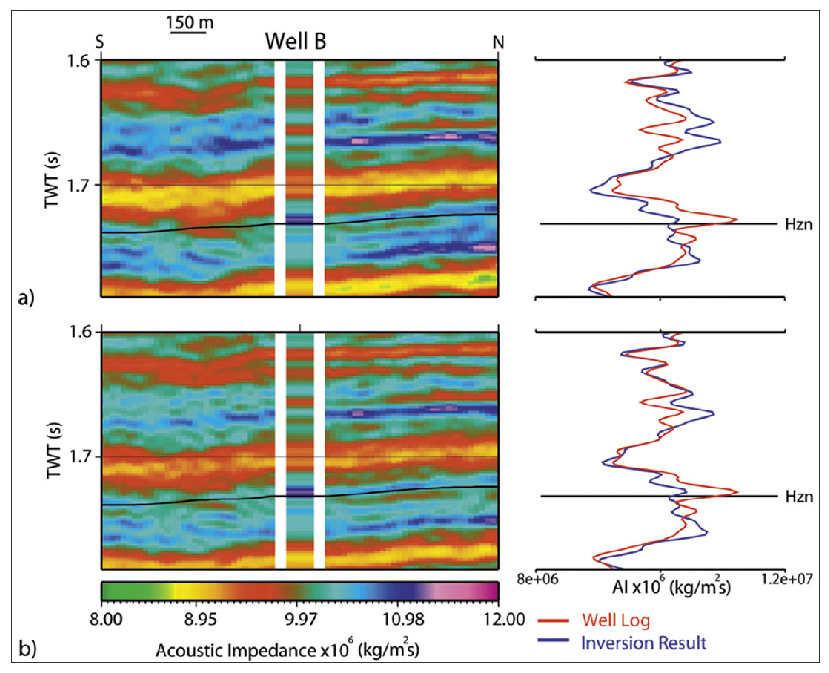

In [14]:
fig05=io.imread('../data/inversion_driven_processing_fig05.png')

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(fig05);

The logs were hand-digitized (by me) so they will require interpolation to regularly-sampled time intervals.

In [15]:
log_a = np.loadtxt('../data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,1]
log_a_t = np.loadtxt('../data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,0]

In [16]:
log_b = np.loadtxt('../data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,1]
log_b_t = np.loadtxt('../data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,0]

In [17]:
inv_a = np.loadtxt('../data/Recorder09_inversion_a.csv', delimiter=',')[:,1]
inv_a_t = np.loadtxt('../data/Recorder09_inversion_a.csv', delimiter=',')[:,0]

In [18]:
inv_b = np.loadtxt('../data/Recorder09_inversion_b.csv', delimiter=',')[:,1]
inv_b_t = np.loadtxt('../data/Recorder09_inversion_b.csv', delimiter=',')[:,0]

In [19]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})
#print(inv_a_t[4:10])
#print(inv_b_t[4:10])

In [20]:
from scipy import interpolate

fina = interpolate.interp1d(inv_a_t, inv_a)
finb = interpolate.interp1d(inv_b_t, inv_b)
floa = interpolate.interp1d(log_a_t, log_a)
flob = interpolate.interp1d(log_b_t, log_b)

time = np.arange(1.604, 1.8, 0.002)

ina = fina(time)
inb = finb(time)
loa = floa(time)
lob = flob(time)

In [21]:
hrzn = np.genfromtxt('../data/Recorder09_tops.csv', delimiter=',')[0,1]
bttm = np.genfromtxt('../data/Recorder09_tops.csv', delimiter=',')[1,1]

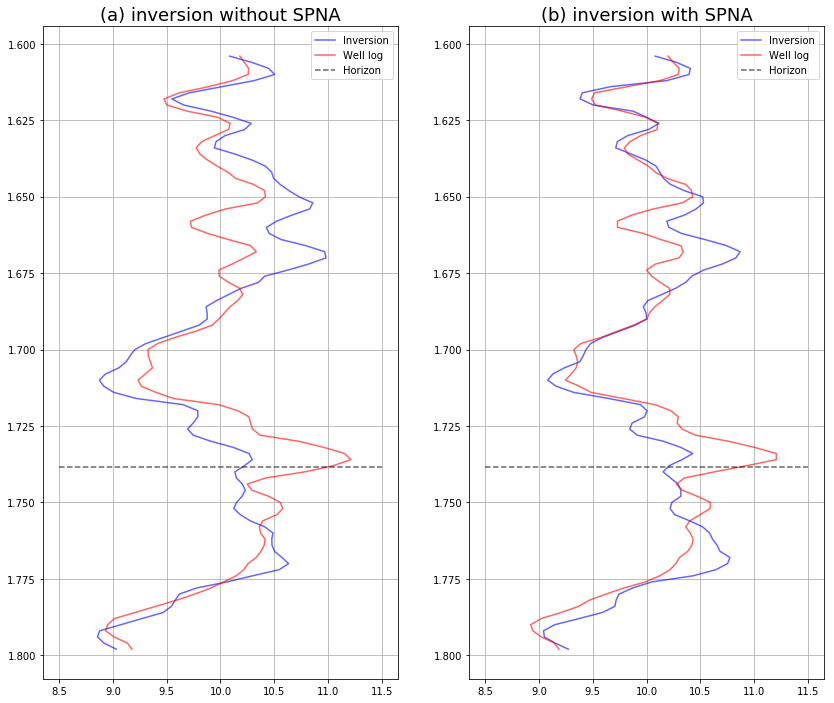

In [22]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(ina,time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(loa,time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(inb,time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(lob,time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);


##### CALCULATING ERROR STATISTICS BY STRATIGRAPHYC UNIT IF ZONE LOG IS PROVIDED

Future work:  make zone log directly from tops

**NB Have to write a test for these two metods**

In [23]:
logs2.describe(include='all')

,DEPTH,ZONE_NUM,VP,predictedVP,oil_zone
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073,0.046173
std,181.053325,2.154977,433.228662,418.308545,0.209884
min,2013.410000,0.000000,2046.660000,2111.090000,0.000000
25%,2168.930000,4.000000,2607.125000,2675.275000,0.000000
50%,2325.670000,4.000000,3050.280000,3029.160000,0.000000
75%,2482.415000,5.000000,3248.900000,3242.245000,0.000000
max,2639.160000,9.000000,4088.760000,4049.990000,1.000000


In [24]:
zones = list(logs2['ZONE_NUM'].unique())
zones

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
mean_abs_err = [np.mean(np.abs(logs2.loc[logs2.ZONE_NUM ==z, 'predictedVP'] 
                               -logs2.loc[logs2.ZONE_NUM ==z, 'VP'])) for z in zones]
mean_abs_err = np.array(mean_abs_err)
print(mean_abs_err)

[109.52667 58.26520 91.92427 46.63881 86.64921 58.34472 130.78758
 105.01095 118.46347 108.42280]


In [26]:
def zone_thickness(d, zone):
    """ returns amount of flagged portion of a zone"""
    #### input ####
    # d= depth log (e.g. logs['DEPT'])
    # zone = stratigraphic zone (e.g. 1 = BALDER)
    
    th = np.amax(d[np.where(logs2['ZONE_NUM']== zone)]) - np.amin(d[np.where(logs2['ZONE_NUM']== zone)])

    return th

In [27]:
thicknesses =  np.array([zone_thickness(np.array(logs2['DEPTH']), z)  for z in zones])
thicknesses

array([12.34000, 48.77000, 50.90000, 26.82000, 303.89000, 32.77000,
       9.90000, 81.83000, 14.78000, 42.37000])